In [1]:
include("main.jl")
using PyCall
using CairoMakie
sepsis_gym = pyimport("custom_sepsis")
using Statistics


/Users/luisastue/miniconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:

struct MeanRewardsType
    mean_rewards::Vector{Float64}
    individual_runs::Vector{Vector{Float64}}
    smoothed_mean::Vector{Float64}
    smoothed_std::Vector{Float64}
    keys_of_smoothed::Vector{Float64}
    name::String
    info::Dict
end
function load_rewards_from_json(file_path)
    json_data = JSON3.read(file_path)
    mean_rewards = [Float64(rew) for rew in json_data["mean_rewards"]]
    individual_runs = [[Float64(rew) for rew in r] for r in json_data["individual_runs"]]
    smoothed_mean = [Float64(rew) for rew in json_data["smoothed_mean"]]
    smoothed_std = [Float64(rew) for rew in json_data["smoothed_std"]]
    keys_of_smoothed = [Int(k) for k in json_data["keys_of_smoothed"]]
    name = json_data["name"]
    info = Dict(
        string(k) => string(v) for (k, v) in json_data["info"]
    )
    return MeanRewardsType(mean_rewards, individual_runs, smoothed_mean, smoothed_std, keys_of_smoothed, name, info)
end

load_rewards_from_json (generic function with 1 method)

In [3]:
rewards = Dict(
    :Simple100 => load_rewards_from_json("json/ts/Simple100.json"),
    :Medium100 => load_rewards_from_json("json/ts/Medium100.json"),
    :None100 => load_rewards_from_json("json/ts/None100.json"),
    # :None100P => load_rewards_from_json("json/ts/None100P.json"),
    :Softmax100 => load_rewards_from_json("json/ts/Softmax100.json"),
    :SimplePPL100 => load_rewards_from_json("json/ts/SimplePPL100.json"),
    :Simple1 => load_rewards_from_json("json/ts/Simple1.json"),
    :Medium1 => load_rewards_from_json("json/ts/Medium1.json"),
    :Softmax1 => load_rewards_from_json("json/ts/Softmax1.json"),
    :SimplePPL1 => load_rewards_from_json("json/ts/SimplePPL1.json"),
    :DQN_S => load_rewards_from_json("json/dqn/small_buff.json"),
    :DQN_SS => load_rewards_from_json("json/dqn/small_buff_small_expl.json"),
    :DQN_L => load_rewards_from_json("json/dqn/large_buff.json"),
    :DQN_M => load_rewards_from_json("json/dqn/medium.json"),
    :QLearning => load_rewards_from_json("json/qlearning/q_learning_results_small_eps.json"),
)

Dict{Symbol, MeanRewardsType} with 14 entries:
  :Softmax1     => MeanRewardsType([-0.67245, -0.750493, -0.7667, -0.81518, -0.…
  :DQN_L        => MeanRewardsType([-0.740741, -0.666667, -0.740741, -0.814815,…
  :SimplePPL100 => MeanRewardsType([-0.624323, -0.453003, -0.38704, -0.38704, -…
  :DQN_M        => MeanRewardsType([-0.666667, -0.619048, -0.761905, -0.714286,…
  :QLearning    => MeanRewardsType([-0.65, -0.62, -0.64, -0.67, -0.73, -0.64, -…
  :Medium100    => MeanRewardsType([-0.671667, -0.64189, -0.64451, -0.64451, -0…
  :Simple100    => MeanRewardsType([-0.671597, -0.62753, -0.618317, -0.618317, …
  :None100      => MeanRewardsType([-0.658183, -0.67427, -0.668743, -0.668743, …
  :Simple1      => MeanRewardsType([-0.60532, -0.60532, -0.634067, -0.55527, -0…
  :Medium1      => MeanRewardsType([-0.668417, -0.668417, -0.666513, -0.650337,…
  :SimplePPL1   => MeanRewardsType([-0.611203, -0.467777, -0.522927, -0.32263, …
  :DQN_SS       => MeanRewardsType([-0.6875, -0.75, -0.5, -0.7

In [4]:
function plot_mean_rewards(means, batch_size, types, x_lim=15000)
    fig = Figure(resolution=(900, 500))  
    ax = Axis(fig[1, 1], xlabel = "Number of Episodes", ylabel = "Mean Reward Across 100'000 Episodes", title = "Mean Rewards for Thompson Sampling with Batch Size $batch_size")

    ts_types = [:Simple100, :Medium100, :None100, :Softmax100, :SimplePPL100, :Simple1, :Medium1, :Softmax1, :SimplePPL1]
    mfrl_types = [:DQN_SS, :DQN_S, :DQN_M, :DQN_L, :QLearning]
    filtered_ts = filter(x -> x in types, ts_types)
    filtered_mfrl = filter(x -> x in types, mfrl_types)
    # Data storage for accessing smoothed values later

    ks = []
    for (i, type) in enumerate(filtered_ts)
        for mean in means[type].individual_runs
            lines!(ax, mean, color=(colors_dict[type], 0.2))
        end
        ks = means[type].keys_of_smoothed
        smoothed_mean_rewards = means[type].smoothed_mean
        lines!(ax, ks, Float64.(smoothed_mean_rewards), color=colors_dict[type], linewidth=1.5, label=label_dict[type])
        smoothed_std_rewards = means[type].smoothed_std
        low = smoothed_mean_rewards .- smoothed_std_rewards
        high = smoothed_mean_rewards .+ smoothed_std_rewards
        band!(ax, ks, low, high, color=(colors_dict[type], 0.2))
    end
    len = x_lim 

    for type in filtered_mfrl
        minlen = minimum([length(means[type].smoothed_mean), length(means[type].smoothed_std)])
        smoothed = means[type].smoothed_mean[1:minlen]
        # low = means[type].smoothed_mean[1:minlen] .- means[type].smoothed_std[1:minlen]
        # smoothed_low = Plot.moving_avg(low, 700)
        # high = means[type].smoothed_mean[1:minlen] .+ means[type].smoothed_std[1:minlen]
        # smoothed_high = Plot.moving_avg(high, 700)

        lines!(ax, 1:length(smoothed), smoothed, color=(colors_dict[type], 0.6),label=label_dict[type])
        # band!(ax, 1:length(smoothed), smoothed_low, smoothed_high, color=(colors_dict[type], 0.2))
    end
    
    lines!(ax, 1:len, fill(random_mean, len), color=:black, linestyle=:dash, label="Random Policy")
    # axislegend(ax, position=(:right, :bottom))

    if x_lim != nothing
        xlims!(ax, 0, x_lim)
    end
    ax.xtickformat = x -> [string(Int(el)) for el in x]

    Legend(fig[1, 2], ax, position = :right)
    
    ylims!(ax, -0.85, 0)
    ax.yticks = -1:0.05:0
    ax.xticks = 0:50:x_lim

    return fig, ax

end


plot_mean_rewards (generic function with 2 methods)

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/Y3ABD/src/scenes.jl:238


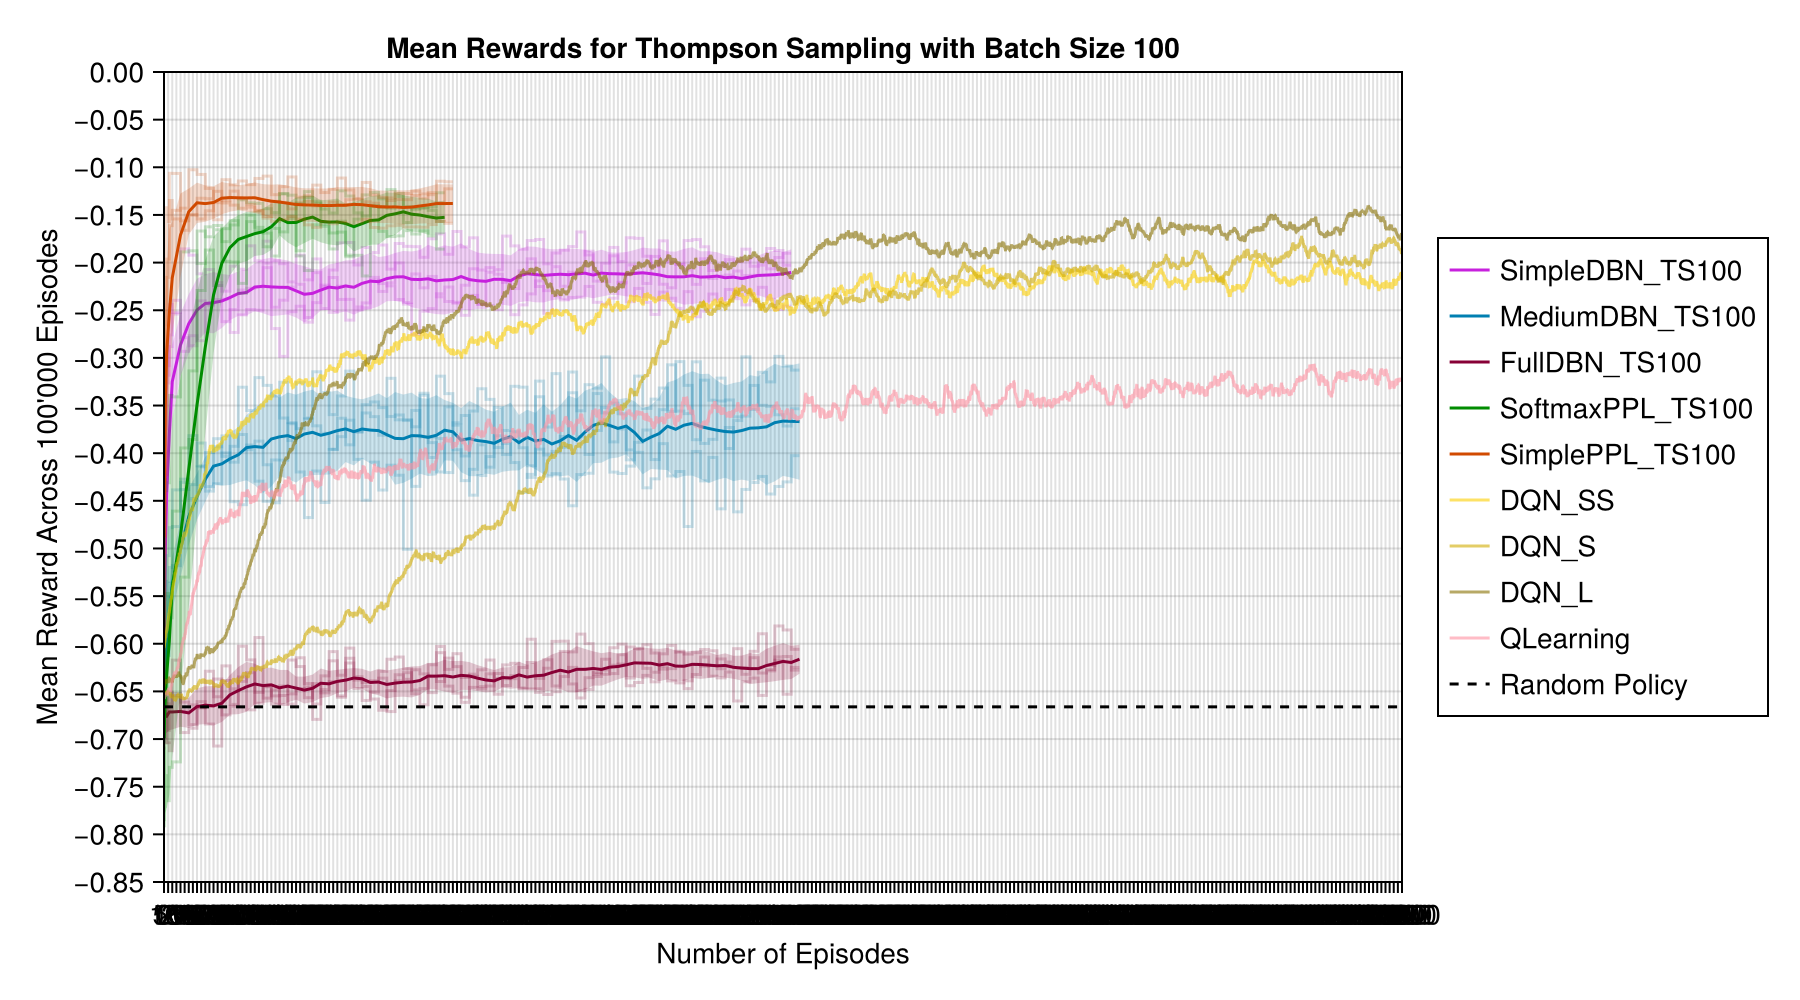

In [5]:
fig, ax = plot_mean_rewards(rewards, 100, [:SimplePPL100, :Softmax100, :Simple100, :Medium100, :None100, :QLearning, :DQN_S, :DQN_L, :DQN_SS], 15000)
save("plots/ts100_dqn.png", fig)
fig

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/Y3ABD/src/scenes.jl:238


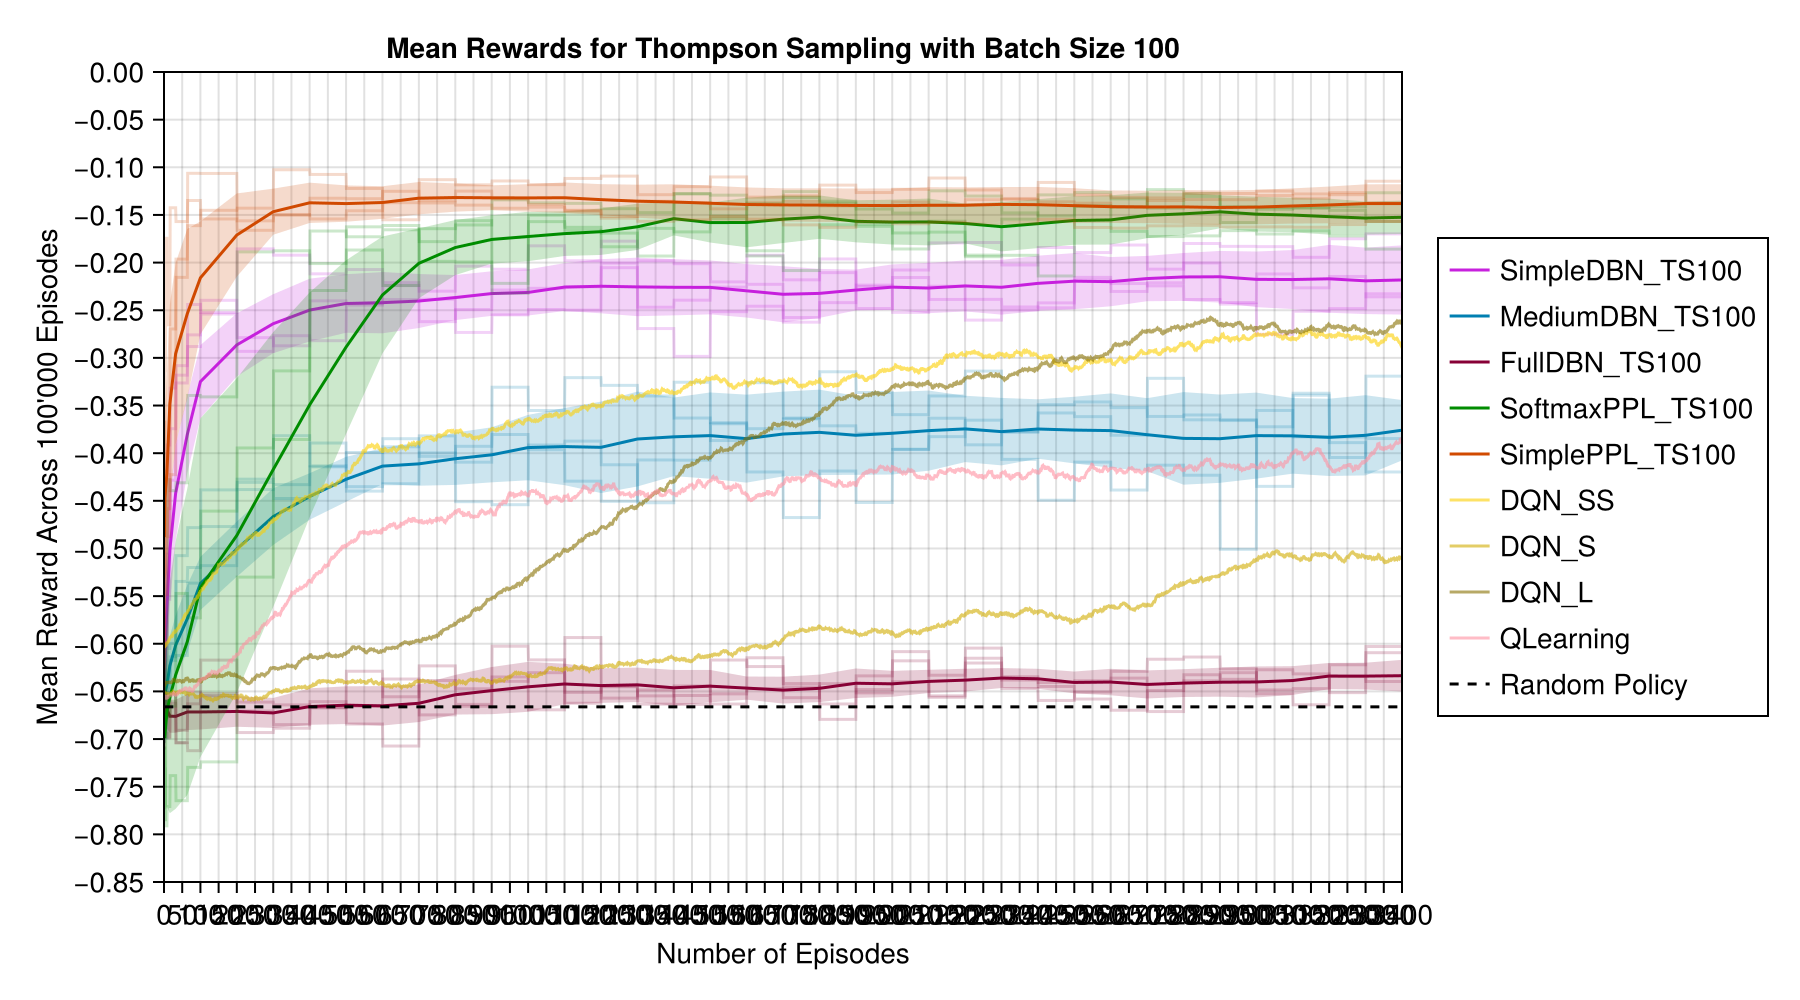

In [6]:
fig, ax = plot_mean_rewards(rewards, 100, [:SimplePPL100, :Softmax100, :Simple100, :Medium100, :None100, :QLearning, :DQN_S, :DQN_L, :DQN_SS], 3400)
save("plots/ts100.png", fig)
fig

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/Y3ABD/src/scenes.jl:238


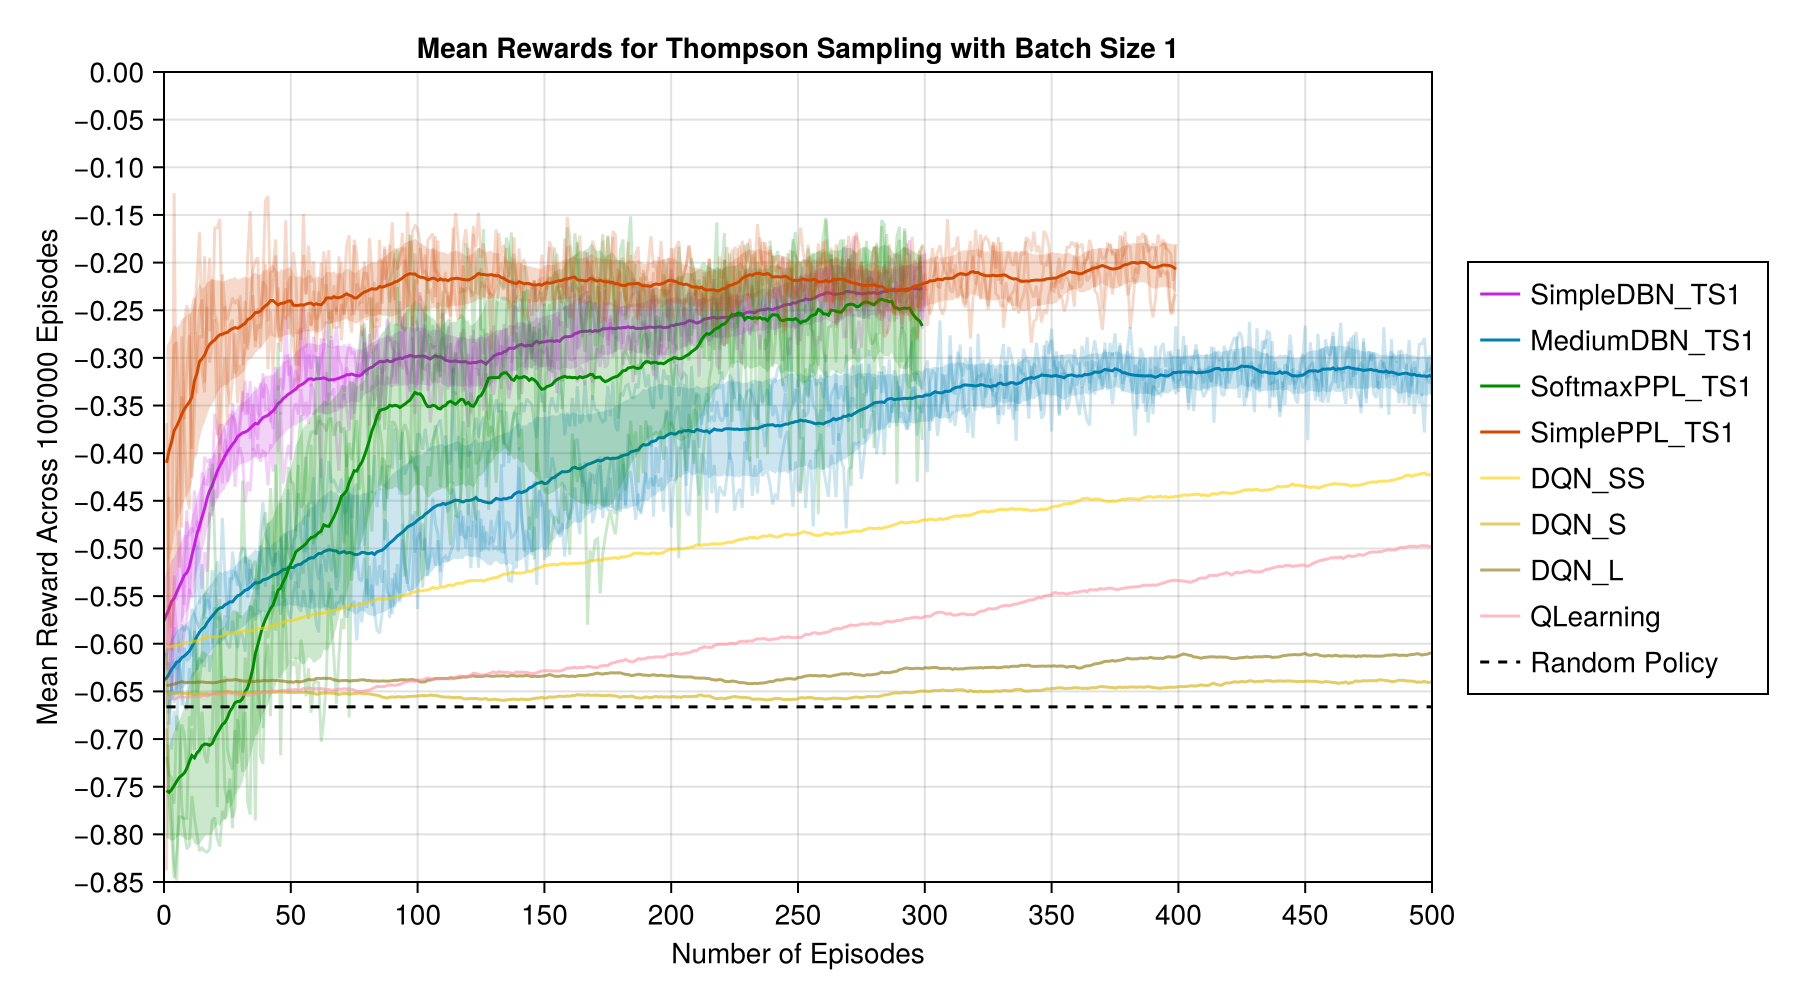

In [7]:
fig, ax = plot_mean_rewards(rewards, 1, [:SimplePPL1, :Softmax1, :Simple1, :Medium1, :None1, :QLearning, :DQN_S, :DQN_L, :DQN_SS], 500)
save("plots/ts1.png", fig)
fig

In [8]:
latex_labels = Dict(
    :Softmax => "\$\\mathsf{SoftmaxPPL}\$",
    :None => "\$\\mathsf{FullDBN}\$",
    :Medium => "\$\\mathsf{MediumDBN}\$",
    :DQN => "\$\\mathsf{DQN}\$",
    :SmoothedDQN => "\$\\mathsf{DQN}\$",
    :Simple => "\$\\mathsf{SimpleDBN}\$",
    :SimplePPL => "\$\\mathsf{SimplePPL}\$",
    :Softmax100 => "\$\\mathsf{SoftmaxPPL\\_100}\$",
    :None100 => "\$\\mathsf{FullDBN\\_100}\$",
    :Medium100 => "\$\\mathsf{MediumDBN\\_100}\$",
    :SmoothedDQN100 => "\$\\mathsf{DQN\\_100}\$",
    :Simple100 => "\$\\mathsf{SimpleDBN\\_100}\$",
    :SimplePPL100 => "\$\\mathsf{SimplePPL\\_100}\$",
    :Softmax1 => "\$\\mathsf{SoftmaxPPL\\_1}\$",
    :Medium1 => "\$\\mathsf{MediumDBN\\_1}\$",
    :SmoothedDQN1 => "\$\\mathsf{DQN\\_1}\$",
    :Simple1 => "\$\\mathsf{SimpleDBN\\_1}\$",
    :SimplePPL1 => "\$\\mathsf{SimplePPL\\_1}\$",
    :DQN_S => "\$\\mathsf{DQN\\_S}\$",
    :DQN_SS => "\$\\mathsf{DQN\\_SS}\$",
    :DQN_L => "\$\\mathsf{DQN\\_L}\$",
    :DQN_M => "\$\\mathsf{DQN\\_M}\$",
    :QLearning => "\$\\mathsf{QLearning}\$",
)

Dict{Symbol, String} with 23 entries:
  :Softmax1       => "\$\\mathsf{SoftmaxPPL\\_1}\$"
  :SmoothedDQN1   => "\$\\mathsf{DQN\\_1}\$"
  :SimplePPL100   => "\$\\mathsf{SimplePPL\\_100}\$"
  :DQN_M          => "\$\\mathsf{DQN\\_M}\$"
  :QLearning      => "\$\\mathsf{QLearning}\$"
  :Medium100      => "\$\\mathsf{MediumDBN\\_100}\$"
  :Simple100      => "\$\\mathsf{SimpleDBN\\_100}\$"
  :None100        => "\$\\mathsf{FullDBN\\_100}\$"
  :Medium1        => "\$\\mathsf{MediumDBN\\_1}\$"
  :Simple1        => "\$\\mathsf{SimpleDBN\\_1}\$"
  :Softmax        => "\$\\mathsf{SoftmaxPPL}\$"
  :SmoothedDQN    => "\$\\mathsf{DQN}\$"
  :SimplePPL1     => "\$\\mathsf{SimplePPL\\_1}\$"
  :DQN_S          => "\$\\mathsf{DQN\\_S}\$"
  :Simple         => "\$\\mathsf{SimpleDBN}\$"
  :DQN_L          => "\$\\mathsf{DQN\\_L}\$"
  :Medium         => "\$\\mathsf{MediumDBN}\$"
  :SmoothedDQN100 => "\$\\mathsf{DQN\\_100}\$"
  :DQN            => "\$\\mathsf{DQN}\$"
  :SimplePPL      => "\$\\mathsf{SimplePPL}\$"
  

In [9]:
function get_cumsums(means)
    cumsums = Dict()
    for (type, mean) in means
        cumsums[type] = cumsum(mean.mean_rewards, dims=1)
    end
    return cumsums
end

get_cumsums (generic function with 1 method)

In [10]:
function get_sample_efficiency(means, checkpoints=[-1:0.05:1])
    sample_eff = Dict()
    for (type, mean) in means
        sample_eff[type] = Dict()
        for checkpoint in checkpoints
            index = findfirst(x -> x >= checkpoint, mean.smoothed_mean)
            sample_eff[type][checkpoint] = isnothing(index) ? NaN : mean.keys_of_smoothed[index]
            # index = findfirst(x -> x >= checkpoint, mean.mean_rewards)
            # sample_eff[type][checkpoint] = isnothing(index) ? NaN : index
        end
    end
    return sample_eff  
end

get_sample_efficiency (generic function with 2 methods)

In [11]:
function get_asymptotic_reward(means, checkpoints=[0.5,0.7,0.9,0.99])
    asymptotic_rewards = Dict{Symbol, Float64}()
    convergence_speeds = Dict{Symbol, Dict{Float64, Int}}()
    lengths = Dict{Symbol, Int}()

    for (type, m) in means
        rewards = m.mean_rewards
        # Store the length of the rewards array
        lengths[type] = length(rewards)
        last_n = Int(round(lengths[type] / 10))

        # Asymptotic mean reward
        if !isempty(rewards)
            asymptotic_rewards[type] = mean(rewards[end-last_n:end])
        else
            asymptotic_rewards[type] = NaN
        end

        # Convergence speed for each checkpoint
        convergence_speeds[type] = Dict()
        for checkpoint in checkpoints
            min_reward = minimum(rewards)
            max_reward = maximum(rewards)
            reward_range = max_reward - min_reward
            threshold_value = min_reward + checkpoint * reward_range
            index = findfirst(x -> x >= threshold_value, rewards)
            if isnothing(index)
                convergence_speeds[type][checkpoint] = NaN  # Indicate no convergence
            else
                convergence_speeds[type][checkpoint] = index
            end
        end
    end
    return asymptotic_rewards, convergence_speeds, lengths
end

get_asymptotic_reward (generic function with 2 methods)

In [12]:
type_order = [[:SimplePPL1, :Softmax1, :Simple1, :Medium1], [:SimplePPL100, :Softmax100, :Simple100, :Medium100, :None100],  [:QLearning, :DQN_L, :DQN_S, :DQN_SS]]

3-element Vector{Vector{Symbol}}:
 [:SimplePPL1, :Softmax1, :Simple1, :Medium1]
 [:SimplePPL100, :Softmax100, :Simple100, :Medium100, :None100]
 [:QLearning, :DQN_L, :DQN_S, :DQN_SS]

In [13]:
using Printf

# Helper function to format best/worst values across types with your adjustments
function format_best_worst_across_types(values_matrix, digs; is_higher_better=true, skip=false)
    rows, cols = size(values_matrix)
    formatted_matrix = Array{String}(undef, rows, cols)  # Initialize a matrix to store formatted values

    for col in 1:cols
        column_values = values_matrix[:, col]
        max_val = maximum(column_values[.!isnan.(column_values)]; init=-typemax(Int64))
        min_val = minimum(column_values[.!isnan.(column_values)]; init=typemax(Int64))
        for row in 1:rows
            v = column_values[row]
            if isnan(v)
                formatted_matrix[row, col] = "-"
            else
                if digs == 0
                    formatted_value = @sprintf("%d", round(v, digits=digs))
                elseif digs == 1
                    formatted_value = @sprintf("%0.1f", round(v, digits=digs))
                elseif digs == 2
                    formatted_value = @sprintf("%0.2f", round(v, digits=digs))
                elseif digs == 3
                    formatted_value = @sprintf("%0.3f", round(v, digits=digs))
                else 
                    formatted_value = v
                end
                if v == max_val && is_higher_better && !skip
                    formatted_matrix[row, col] = "\\color{blue}{\$$(formatted_value)\$}"
                elseif v == min_val && !is_higher_better&& !skip
                    formatted_matrix[row, col] = "\\color{blue}{\$$(formatted_value)\$}"
                elseif v == min_val && is_higher_better&& !skip
                    formatted_matrix[row, col] = "\\color{red}{\$$(formatted_value)\$}"
                elseif v == max_val && !is_higher_better&& !skip
                    formatted_matrix[row, col] = "\\color{red}{\$$(formatted_value)\$}"
                else
                    formatted_matrix[row, col] = "\$$(formatted_value)\$"
                end
            end
        end
    end
    return formatted_matrix
end

# Generate LaTeX table for cumulative rewards
function generate_cumulative_rewards_table(cumsums, checkpoints)
    types = collect(keys(cumsums))
    cols = length(checkpoints)
    
    # Collect rewards for each type at each checkpoint into a matrix
    values_matrix = [length(cumsums[type]) >= chk ? cumsums[type][chk-1] : NaN for type in types, chk in checkpoints]

    # Format the values with best/worst highlighting
    formatted_matrix = format_best_worst_across_types(values_matrix, 2, is_higher_better=true)

    # Create LaTeX table
    header = "\\hline\n & \$" * join(checkpoints, "\$ & \$") * "\$ \\\\\n\\hline\n"
    rows = Dict()
    for (i, type) in enumerate(types)
        rows[type] = "$(latex_labels[type]) & " * join(formatted_matrix[i, :], " & ") * " \\\\\n"
    end
    rows_text = ""
    for ts in type_order
        for type in ts
            rows_text *= rows[type]
        end
        rows_text *= "\\hline\n"
    end
    return "\\begin{tabular}{|l|" * "r"^cols * "|}\n\\hline\n" * header * rows_text * "\\hline\n\\end{tabular}"
end

# Generate LaTeX table for sample efficiency
function generate_sample_efficiency_table(sample_eff, checkpoints, lengths)
    types = collect(keys(sample_eff))
    cols = length(checkpoints)
    
    # Collect sample efficiencies into a matrix
    values_matrix = [sample_eff[type][chk] for type in types, chk in checkpoints]

    # Format the values with best/worst highlighting
    formatted_matrix = format_best_worst_across_types(values_matrix, 0, is_higher_better=false)

    # Create LaTeX table
    header = "\\hline\n & \$" * join(checkpoints, "\$ & \$") * "\$ & Length \\\\\n\\hline\n"
    rows = Dict()
    for (i, type) in enumerate(types)
        rows[type] = "$(latex_labels[type]) & " * join(formatted_matrix[i, :], " & ") * " & \$$(lengths[type])\$ \\\\\n"
    end

    rows_text = ""
    for ts in type_order
        for type in ts
            rows_text *= rows[type]
        end
        rows_text *= "\\hline\n"
    end
    return "\\begin{tabular}{|l|" * "r"^cols * "|r|}\n\\hline\n" * header * rows_text * "\\hline\n\\end{tabular}"
end

# Generate LaTeX table for asymptotic rewards
function generate_asymptotic_rewards_table(asymptotic_rewards, convergence_speeds, checkpoints, lengths)
    types = collect(keys(asymptotic_rewards))
    cols = length(checkpoints)
    
    # Collect convergence speeds into a matrix
    conv_matrix = [convergence_speeds[type][chk] for type in types, chk in checkpoints]
    asym_matrix = [asymptotic_rewards[type] for type in types, chk in [1]]

    # Format the values with best/worst highlighting
    formatted_conv = format_best_worst_across_types(conv_matrix, 0, is_higher_better=false, skip=true)
    formatted_asym = format_best_worst_across_types(asym_matrix, 3, is_higher_better=true, )
    percentages = ["\$$(Int(chk*100))\\%\$" for chk in checkpoints]
    # Create LaTeX table
    header = "\\hline\n & Asympt.~Rew. & " * join(percentages, " & ") * " & Length \\\\\n\\hline\n"
    rows = Dict()
    for (i, type) in enumerate(types)
        rows[type] = "$(latex_labels[type]) & {$(formatted_asym[i,1])} & " * 
                     join(formatted_conv[i, :], " & ") * " & \$$(lengths[type])\$ \\\\\n"
    end
    rows_text = ""
    for ts in type_order
        for type in ts
            rows_text *= rows[type]
        end
        rows_text *= "\\hline\n"
    end
    return "\\begin{tabular}{|l|r|" * "r"^cols * "|r|}\n\\hline\n" * header * rows_text * "\\hline\n\\end{tabular}"
end




generate_asymptotic_rewards_table (generic function with 1 method)

In [14]:
cumsums = get_cumsums(rewards)
sample_eff = get_sample_efficiency(rewards, [-0.6,-0.5,-0.4,-0.3,-0.2,-0.1])
asymptotic_rewards, convergence_speeds, lengths = get_asymptotic_reward(rewards, [0.6,0.7,0.8,0.9,0.99])


# Generate tables
cumulative_table = generate_cumulative_rewards_table(cumsums, [10,100,150,400,1000,3000])
sample_eff_table = generate_sample_efficiency_table(sample_eff, [-0.6,-0.5,-0.4,-0.3,-0.2,-0.1], lengths)
asymptotic_table = generate_asymptotic_rewards_table(asymptotic_rewards, convergence_speeds, [0.6,0.7,0.8,0.9,0.99], lengths)

# Print LaTeX tables
println(cumulative_table)

\begin{tabular}{|l|rrrrrr|}
\hline
\hline
 & $10$ & $100$ & $150$ & $400$ & $1000$ & $3000$ \\
\hline
$\mathsf{SimplePPL\_1}$ & \color{blue}{$-3.77$} & $-25.91$ & $-36.82$ & - & - & - \\
$\mathsf{SoftmaxPPL\_1}$ & \color{red}{$-6.80$} & $-53.18$ & $-70.00$ & - & - & - \\
$\mathsf{SimpleDBN\_1}$ & $-5.19$ & $-36.86$ & $-51.69$ & - & - & - \\
$\mathsf{MediumDBN\_1}$ & $-5.79$ & $-52.99$ & $-75.43$ & $-164.51$ & - & - \\
\hline
$\mathsf{SimplePPL\_100}$ & $-3.78$ & \color{blue}{$-21.82$} & \color{blue}{$-28.58$} & \color{blue}{$-64.26$} & \color{blue}{$-143.31$} & \color{blue}{$-422.26$} \\
$\mathsf{SoftmaxPPL\_100}$ & $-6.26$ & $-58.21$ & $-83.68$ & $-176.00$ & $-286.61$ & $-596.47$ \\
$\mathsf{SimpleDBN\_100}$ & $-5.36$ & $-34.38$ & $-46.83$ & $-109.72$ & $-251.75$ & $-697.69$ \\
$\mathsf{MediumDBN\_100}$ & $-5.86$ & $-55.63$ & $-79.55$ & $-188.78$ & $-432.30$ & $-1194.55$ \\
$\mathsf{FullDBN\_100}$ & $-6.05$ & \color{red}{$-67.35$} & \color{red}{$-99.44$} & \color{red}{$-266.89$} & \co

In [15]:
println(sample_eff_table)

\begin{tabular}{|l|rrrrrr|r|}
\hline
\hline
 & $-0.6$ & $-0.5$ & $-0.4$ & $-0.3$ & $-0.2$ & $-0.1$ & Length \\
\hline
$\mathsf{SimplePPL\_1}$ & $1$ & \color{blue}{$1$} & \color{blue}{$2$} & \color{blue}{$16$} & $385$ & - & $399$ \\
$\mathsf{SoftmaxPPL\_1}$ & $38$ & $54$ & $80$ & $201$ & - & - & $299$ \\
$\mathsf{SimpleDBN\_1}$ & \color{blue}{$0$} & $12$ & $25$ & $95$ & - & - & $300$ \\
$\mathsf{MediumDBN\_1}$ & $12$ & $87$ & $184$ & $668$ & - & - & $925$ \\
\hline
$\mathsf{SimplePPL\_100}$ & $1$ & \color{blue}{$1$} & $16$ & $32$ & \color{blue}{$200$} & - & $3500$ \\
$\mathsf{SoftmaxPPL\_100}$ & $64$ & $200$ & $400$ & $500$ & $800$ & - & $3400$ \\
$\mathsf{SimpleDBN\_100}$ & $8$ & $32$ & $64$ & $200$ & - & - & $7600$ \\
$\mathsf{MediumDBN\_100}$ & $64$ & $300$ & $1000$ & - & - & - & $7700$ \\
$\mathsf{FullDBN\_100}$ & - & - & - & - & - & - & $7700$ \\
\hline
$\mathsf{QLearning}$ & $223$ & $487$ & $3097$ & \color{red}{$16495$} & - & - & $30000$ \\
$\mathsf{DQN\_L}$ & $652$ & $1117$ & $15

In [16]:

println(asymptotic_table)

\begin{tabular}{|l|r|rrrrr|r|}
\hline
\hline
 & Asympt.~Rew. & $60\%$ & $70\%$ & $80\%$ & $90\%$ & $99\%$ & Length \\
\hline
$\mathsf{SimplePPL\_1}$ & {$-0.204$} & $4$ & $12$ & $14$ & $34$ & $273$ & $399$ \\
$\mathsf{SoftmaxPPL\_1}$ & {$-0.251$} & $45$ & $78$ & $90$ & $217$ & $248$ & $299$ \\
$\mathsf{SimpleDBN\_1}$ & {$-0.230$} & $27$ & $48$ & $79$ & $138$ & $271$ & $300$ \\
$\mathsf{MediumDBN\_1}$ & {$-0.293$} & $114$ & $181$ & $205$ & $339$ & $750$ & $925$ \\
\hline
$\mathsf{SimplePPL\_100}$ & {\color{blue}{$-0.136$}} & $17$ & $33$ & $33$ & $65$ & $401$ & $3500$ \\
$\mathsf{SoftmaxPPL\_100}$ & {$-0.153$} & $301$ & $301$ & $401$ & $501$ & $1401$ & $3400$ \\
$\mathsf{SimpleDBN\_100}$ & {$-0.213$} & $17$ & $33$ & $65$ & $501$ & $1201$ & $7600$ \\
$\mathsf{MediumDBN\_100}$ & {$-0.369$} & $201$ & $201$ & $701$ & $1401$ & $5301$ & $7700$ \\
$\mathsf{FullDBN\_100}$ & {\color{red}{$-0.621$}} & $101$ & $901$ & $2001$ & $2201$ & $7401$ & $7700$ \\
\hline
$\mathsf{QLearning}$ & {$-0.271$} & $5